<a href="https://colab.research.google.com/github/swilsonmfc/nlp/blob/master/SentenceEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentence Embeddings

![](https://i0.wp.com/datasciencevademecum.com/wp-content/uploads/2020/05/Universal-Sentence-Encoder.png?resize=825%2C318&ssl=1)

# Install

In [1]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 7.3 MB/s 
     |████████████████████████████████| 6.8 MB 50.1 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 895 kB 61.4 MB/s 
     |████████████████████████████████| 596 kB 68.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install sentence-transformers

     |████████████████████████████████| 79 kB 4.3 MB/s 
     |████████████████████████████████| 1.2 MB 42.1 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=e2abca9e70186ec9259fa0ff88fe8f17fbb980453ae71db32691583cf4e7e193
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers


# Clone InferSent

In [3]:
!git clone https://github.com/facebookresearch/InferSent.git

Cloning into 'InferSent'...
remote: Enumerating objects: 259, done.
remote: Total 259 (delta 0), reused 0 (delta 0), pack-reused 259
Receiving objects: 100% (259/259), 424.15 KiB | 6.95 MiB/s, done.
Resolving deltas: 100% (135/135), done.


In [4]:
!ls

InferSent  sample_data


In [5]:
!mkdir InferSent/encoder
!curl -Lo InferSent/encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl
!curl -Lo InferSent/encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  31.3M      0  0:00:04  0:00:04 --:--:-- 31.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  35.7M      0  0:00:04  0:00:04 --:--:-- 35.7M


In [6]:
# mkdir GloVe
# curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
# unzip GloVe/glove.840B.300d.zip -d GloVe/

In [7]:
!mkdir fastText
!curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip fastText/crawl-300d-2M.vec.zip -d fastText/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1453M  100 1453M    0     0  27.7M      0  0:00:52  0:00:52 --:--:-- 29.6M
Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  


# Clone Contrastive-Tension

In [8]:
!git clone https://github.com/FreddeFrallan/Contrastive-Tension contrastive_tension

Cloning into 'contrastive_tension'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 149 (delta 8), reused 10 (delta 3), pack-reused 126
Receiving objects: 100% (149/149), 440.47 KiB | 3.83 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [9]:
!ls

contrastive_tension  fastText  InferSent  sample_data


# Setup


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gensim.downloader as api
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import tensorflow as tf
import tensorflow_hub as hub

import transformers
from transformers import BertTokenizer
from transformers import TFBertModel

import torch
from InferSent.models import InferSent

from contrastive_tension.ContrastiveTension import Inference

import nltk
nltk.download('punkt')
from nltk.tokenize.treebank import TreebankWordTokenizer

from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data
* Stop Clickbait: Detecting and Preventing Clickbaits in Online News Media
* 2016 IEEE/ACM International Conference on Advances in Social Networks Analysis and Mining (ASONAM)
* http://cse.iitkgp.ac.in/~abhijnan/papers/chakraborty_clickbait_asonam16.pdf

## Download

In [11]:
!wget -O clickbait_data.gz https://github.com/bhargaviparanjape/clickbait/raw/master/dataset/clickbait_data.gz
!wget -O non_clickbait_data.gz https://github.com/bhargaviparanjape/clickbait/raw/master/dataset/non_clickbait_data.gz

--2022-02-16 11:16:44--  https://github.com/bhargaviparanjape/clickbait/raw/master/dataset/clickbait_data.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bhargaviparanjape/clickbait/master/dataset/clickbait_data.gz [following]
--2022-02-16 11:16:44--  https://raw.githubusercontent.com/bhargaviparanjape/clickbait/master/dataset/clickbait_data.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345283 (337K) [application/octet-stream]
Saving to: ‘clickbait_data.gz’

clickbait_data.gz   100%[===================>] 337.19K  --.-KB/s    in 0.02s   

2022-02-16 11:16:44 (15.1 MB/s) - ‘clickbait_d

In [12]:
!gunzip clickbait_data.gz
!gunzip non_clickbait_data.gz

In [13]:
!head clickbait_data

Should I Get Bings

Which TV Female Friend Group Do You Belong In

The New "Star Wars: The Force Awakens" Trailer Is Here To Give You Chills

This Vine Of New York On "Celebrity Big Brother" Is Fucking Perfect

A Couple Did A Stunning Photo Shoot With Their Baby After Learning She Had An Inoperable Brain Tumor



In [14]:
!head non_clickbait_data

Bill Changing Credit Card Rules Is Sent to Obama With Gun Measure Included
In Hollywood, the Easy-Money Generation Toughens Up
1700 runners still unaccounted for in UK's Lake District following flood

Yankees Pitchers Trade Fielding Drills for Putting Practice
Large earthquake rattles Indonesia; Seventh in two days

Coldplay's new album hits stores worldwide this week

U.N. Leader Presses Sri Lanka on Speeding Relief to War Refugees in Camps


## Read Clicks

In [15]:
click = []
with open('clickbait_data', 'r') as f:
  for line in f.readlines():
    if len(line) > 0 and line != '\n':
      click.append(line)
print(len(click))
click[0:10]

15999


['Should I Get Bings\n',
 'Which TV Female Friend Group Do You Belong In\n',
 'The New "Star Wars: The Force Awakens" Trailer Is Here To Give You Chills\n',
 'This Vine Of New York On "Celebrity Big Brother" Is Fucking Perfect\n',
 'A Couple Did A Stunning Photo Shoot With Their Baby After Learning She Had An Inoperable Brain Tumor\n',
 'How To Flirt With Queer Girls Without Making A Total Fool Of Yourself\n',
 '32 Cute Things To Distract From Your Awkward Thanksgiving\n',
 'If Disney Princesses Were From Florida\n',
 "What's A Quote Or Lyric That Best Describes Your Depression\n",
 'Natalie Dormer And Sam Claflin Play A Game To See How They\'d Actually Last In "The Hunger Games"\n']

## Read Non-Clicks

In [16]:
non_click = []
with open('non_clickbait_data', 'r') as f:
  for line in f.readlines():
    if len(line) > 0 and line != '\n':
      non_click.append(line)
print(len(non_click))
non_click[0:10]

16001


['Bill Changing Credit Card Rules Is Sent to Obama With Gun Measure Included\n',
 'In Hollywood, the Easy-Money Generation Toughens Up\n',
 "1700 runners still unaccounted for in UK's Lake District following flood\n",
 'Yankees Pitchers Trade Fielding Drills for Putting Practice\n',
 'Large earthquake rattles Indonesia; Seventh in two days\n',
 "Coldplay's new album hits stores worldwide this week\n",
 'U.N. Leader Presses Sri Lanka on Speeding Relief to War Refugees in Camps\n',
 '2 Somali-Americans Charged With Aiding Terror\n',
 "US Highway Administration releases interim report on Boston's Big Dig: press release claims tunnel safe, but report does not\n",
 'White House Announces International Meetings to Address Energy and Climate Issues\n']

## Create Corpus & Targets

In [17]:
target = [1] * len(click) + [0] * len(non_click)
print(len(target))

32000


In [18]:
corpus = click + non_click
print(len(corpus))

32000


## Test Train

In [20]:
train, test, y_train, y_test = train_test_split(corpus, target, random_state=4001)
print(len(train), len(y_train))
print(len(test), len(y_test))

24000 24000
8000 8000


# Comparison

In [21]:
results_df = pd.DataFrame(columns=['Score', 'Embedding Dimension'])

# Word Vectors

![](https://raw.githubusercontent.com/rohan-varma/paper-analysis/master/word2vec-papers/models.png)

## AWE Average Word Embeddings

In [22]:
w2v_model = api.load("glove-wiki-gigaword-50")
w2v_tokenizer = TreebankWordTokenizer()

[==================================================] 100.0% 66.0/66.0MB downloaded


In [44]:
UNK = np.array([0.] * 50)

def awe_embedding(model, tokenizer, sentence):
  tokens = tokenizer.tokenize(sentence)
  for token in tokens:
    embedding = []
    try:
      vector = model.get_vector(token.lower())
      embedding.append(vector)
    except:
      pass
    
    if len(embedding) == 0:
      return UNK
    
    return np.mean(embedding, axis=0)

In [45]:
X_train = []
for doc in train:
  embedding = awe_embedding(w2v_model, w2v_tokenizer, doc)
  X_train.append(embedding)

X_test = []
for doc in test:
  embedding = awe_embedding(w2v_model, w2v_tokenizer, doc)
  X_test.append(embedding)

In [46]:
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

(24000, 50)
(8000, 50)


In [47]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
results_df.loc['Word2Vec[50]'] = [score, X_train.shape[1]]
score

0.934625

## Paragraph Vectors
* https://arxiv.org/abs/1405.4053
* https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html
* Unsupervised algorithm
* Learns fixed-length feature representations from variable length text
* Trains word and paragraph vectors using SGD / BackProp
  * Shares word vectors
  * Paragraph vectors unique
  * Inference - Paragraph vectors are inferred by fixing word vectors and training on new paragraph
* Results - 2014
  * Outperformed BOW by 30% 
  * SOTA on Text Classification & Sentiment Analysis Tasks 
* Distributed Memory tends to outperform DBOW
  * Default model in Gensim

![](https://i.stack.imgur.com/t7slV.png)

### Small

In [48]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
d2v_model = Doc2Vec(documents, vector_size=50, window=2, min_count=1, workers=4)

In [49]:
X_train = []
for doc in train:
  vector = d2v_model.infer_vector(doc)
  X_train.append(vector)

X_test = []
for doc in test:
  vector = d2v_model.infer_vector(doc)
  X_test.append(vector)

In [50]:
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

(24000, 50)
(8000, 50)


In [51]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
results_df.loc['ParagraphVectors[50]'] = [score, X_train.shape[1]]
score

0.870875

### Large

In [52]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
d2v_model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

In [53]:
X_train = []
for doc in train:
  vector = d2v_model.infer_vector(doc)
  X_train.append(vector)

X_test = []
for doc in test:
  vector = d2v_model.infer_vector(doc)
  X_test.append(vector)

In [54]:
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

(24000, 100)
(8000, 100)


In [55]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
results_df.loc['ParagraphVectors[100]'] = [score, X_train.shape[1]]
score

0.875375

# Unsupervised

## Skip-Thought Vectors
* https://arxiv.org/abs/1506.06726
* https://github.com/ryankiros/skip-thoughts
* Name inspired by Hinton
* Goal is to map word vectors into sentence vectors
* Inspired by word2vec skip-gram model
* Instead of a word to predict surrounding context
* Encode a sentence to predict sentences around it


![](https://cdn-images-1.medium.com/max/1200/1*MQXaRQ3BsTHpn0cfOXcbag.png)

## Quick-Thought Vectors
* https://arxiv.org/pdf/1803.02893.pdf
* https://github.com/RRisto/quickthoughts
* Skip-Thoughts is computationally expensive
  * Word level reconstruction involves sequentially decoding words
  * Training over softmax for large vocabulary expensive
  * There are tricks though - hierarchical & negative sampling
* Key idea
  * Replace the generative objective 
  * Use a discriminative approximation
  * Identify the embedding of a correct target given sentence candidates
* Named Quick-Thought around this improvement in efficiency

## Context2Vec
* https://aclanthology.org/K16-1006
* https://github.com/orenmel/context2vec
* Context2Vec is an unsupervised model
* Based on Word2Vec CBOW
* Learns generic context embedding using bidirectional word embeddings 
  * Words fed into model left-right and right-left
  * Passed through MLP
* Learns a joint embedding of sentences and words
  * Negative Sampling Objective Function


![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-27_at_12.31.55_PM.png)

## Universal Sentence Encoder
* https://arxiv.org/abs/1803.11175
* https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder
* Paper presents two approaches for sentence embeddings
  * Transformer - higher accuracy, higher resource
  * Deep average network - lower accuracy, lower resource
* Transfer Encoder
  * Penn-Text-Bank Tokenizer
  * 512 Dimension
  * Multi-task learning
  * Training 
    * Multi-task single encoding model
    * Skip-Thought like - unsupervised task
    * Conversational input-response task
    * Classification tasks - supervised task
* Deep Averaging Network
  * Similar to Transfer Encoder
  * Input Embeddings Averaged
  * Passed through FFN
  * Strong Baseline
* Model made available on TF-Hub


![](https://amitness.com/images/use-transformer-variant.png)

![](https://amitness.com/images/use-overall-pipeline.png)

![](https://amitness.com/images/use-word-embedding-average.png)

In [56]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
use_model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [57]:
def embed(input):
  return use_model(input)

In [58]:
X_train = embed(train)
X_test  = embed(test)

In [59]:
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

(24000, 512)
(8000, 512)


In [60]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
results_df.loc['UniversalSentenceEncoder'] = [score, X_train.shape[1]]
score

0.962625

# BERT

## BERT Base

In [61]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### CLS Token

![](https://yashuseth.files.wordpress.com/2019/06/fig2-1.png)

In [62]:
batch = 1000
train_batches = len(train) // batch

X_train = []
for i in range(train_batches):
  start = i * batch
  end   = (i + 1) * batch
  if end > len(train):
    end = len(train)

  print(start, end)
  inputs = bert_tokenizer(train[start:end], return_tensors="tf", padding=True)
  output = bert_model(inputs)
  X_train.extend(output['pooler_output'])

0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000
20000 21000
21000 22000
22000 23000
23000 24000


In [63]:
batch = 1000
test_batches = len(test) // batch

X_test = []
for i in range(test_batches):
  start = i * batch
  end   = (i + 1) * batch
  if end > len(test):
    end = len(test)

  print(start, end)
  inputs = bert_tokenizer(test[start:end], return_tensors="tf", padding=True)
  output = bert_model(inputs)
  X_test.extend(output['pooler_output'])

0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000


In [64]:
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

(24000, 768)
(8000, 768)


In [65]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
results_df.loc['BERT-CLS'] = [score, X_train.shape[1]]
score

0.952375

### Average Embedding

![](https://yashuseth.files.wordpress.com/2019/06/fig2-1.png)

In [66]:
batch = 1000
train_batches = len(train) // batch

X_train = []
for i in range(train_batches):
  start = i * batch
  end   = (i + 1) * batch
  if end > len(train):
    end = len(train)

  print(start, end)
  inputs = bert_tokenizer(train[start:end], return_tensors="tf", padding=True)
  output = bert_model(inputs)
  awe = np.delete(output['last_hidden_state'], 0, 1)
  awe = np.mean(awe, axis=1)
  X_train.extend(awe)

0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000
20000 21000
21000 22000
22000 23000
23000 24000


In [67]:
batch = 1000
test_batches = len(test) // batch

X_test = []
for i in range(test_batches):
  start = i * batch
  end   = (i + 1) * batch
  if end > len(test):
    end = len(test)

  print(start, end)
  inputs = bert_tokenizer(test[start:end], return_tensors="tf", padding=True)
  output = bert_model(inputs)
  awe = np.delete(output['last_hidden_state'], 0, 1)
  awe = np.mean(awe, axis=1)
  X_test.extend(awe)

0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000


In [68]:
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

(24000, 768)
(8000, 768)


In [69]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
results_df.loc['BERT-AWE'] = [score, X_train.shape[1]]
score

0.971625

## Sentence-BERT
* https://arxiv.org/abs/1908.10084
* https://github.com/UKPLab/sentence-transformers
* S-BERT
  * How do we make many comparisons?  
    * Find closest sentences between two large books?
    * Find closest paragrapsh in a library?
    * Running CLS <1> SEP <2> SEP on each possible pair is prohibitive
  * Fixed size vectors for input sentences
  * Uses a Siamese Network Architecture
  * Fine tune SBERT on NLI data outperforming
    * InferSent
    * Universal Sentence Encoder
    * SentEval
  * Generate Sentence Embeddings
    * Compare using Cosine-Similarity
* BERT Embeddings 
  * Difficult to derive sentence embeddings
    * Average BERT embeddings
    * CLS Token
  * Ablates pooling operation to BERT Outputs
    * CLS
    * MEAN (all output) -- **Performs Best**
    * MAX (over all output)
  * Fine-Tune - Triplet Loss
    * Anchor Sentence (a)
    * Positive Sentence (p)
    * Negative Sentence (n)
    * Max( ||S(a) - S(p)|| - ||S(a) - S(n)|| + E, 0)
    * Distance between (a) and (p), smaller than (a) and (n) 

![](https://roomylee.github.io/assets/images/blog/2020-02-20-sentence-bert/figure1-and-2.png)

### Small Model
* all-MiniLM-L6-v2 - 384 Parameters
* 80 MB Size
* Avg Performance 58.80 

In [70]:
sent_model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [71]:
X_train = sent_model.encode(train)
X_test = sent_model.encode(test)

In [72]:
print(X_train.shape)
print(X_test.shape)

(24000, 384)
(8000, 384)


In [73]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
results_df.loc['Sentence-Transformer[all-MiniLM-L6-v2]'] = [score, X_train.shape[1]]
score 

0.939

### Large Model
* 5x slower than all-MiniLM-L6-v2 (But still quick on this task)
* all-mpnet-base-v2 - 768 Parameters
* 480 MB Size
* Avg Performance 63.30 

In [74]:
sent_model = SentenceTransformer('all-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [75]:
X_train = sent_model.encode(train)
X_test = sent_model.encode(test)

In [76]:
print(X_train.shape)
print(X_test.shape)

(24000, 768)
(8000, 768)


In [77]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
results_df.loc['Sentence-Transformer[all-mpnet-base-v2]'] = [score, X_train.shape[1]]
score 

0.955375

# Supervised

## InferSent
* https://arxiv.org/abs/1705.02364
* https://github.com/facebookresearch/InferSent
* Natural Language Inference Task
  * SNLI - 570k Human Generated Sentence Pairs
  * Entail, Contradict, Neutral
* Models
  * Separate the encoding of the sentences
  * Joint methods allow encoding of both (u, v, diff, dot)
* Paper Compares
  * Sentence embeddings on several tasks
  * Different encode model strategies
* Finds Bi-Directional LSTM on SNLI with max pooling performs best 


![](https://miro.medium.com/max/972/1*efWq1UrOcGy2E-34OxsBHQ.png)

In [78]:
MODEL_VERSION = 2
MODEL_PATH = f'InferSent/encoder/infersent{MODEL_VERSION}.pkl'
params_model = {'bsize': 64, 
                'word_emb_dim': 300, 
                'enc_lstm_dim': 2048,
                'pool_type': 'max', 
                'dpout_model': 0.0, 
                'version': MODEL_VERSION}
infersent_model = InferSent(params_model)
infersent_model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [79]:
USE_CUDA = True
infersent_model = infersent_model.cuda() if USE_CUDA else infersent_model

In [80]:
W2V_PATH = 'GloVe/glove.840B.300d.txt' if MODEL_VERSION == 1 else 'fastText/crawl-300d-2M.vec'
infersent_model.set_w2v_path(W2V_PATH)

In [81]:
infersent_model.build_vocab(corpus, tokenize=True)

Found 28813(/30303) words with w2v vectors
Vocab size : 28813


In [82]:
X_train = infersent_model.encode(train, tokenize=True)
X_test = infersent_model.encode(test, tokenize=True)

/content/InferSent/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]


In [83]:
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

(24000, 4096)
(8000, 4096)


In [84]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
results_df.loc['InferSent'] = [score, X_train.shape[1]]
score

0.982625

## Contrastive Tension
* https://openreview.net/pdf?id=Ov_sMNau-PF
* https://github.com/FreddeFrallan/Contrastive-Tension
* Pre-Training imposes a large bias on the final layers of a model
  * S-BERT pools fixed size embedding on final transformer layer
  * S-BERT then fine tunes on a NLI task
  * Paper finds no compelling reason for it to perform well
  * NLI requires labeled data
* Cosine similarity in narrow cone in transformers
* Contrastive Tension
  * Dot product (Max if same, Min if different)
  * Non-constructive - doesn't add information to model
  * Forces model to realign cosine-similarity


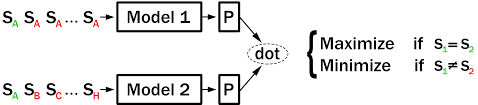

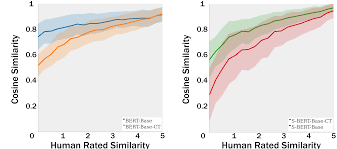

In [85]:
ct_tokenizer = transformers.AutoTokenizer.from_pretrained('Contrastive-Tension/RoBerta-Large-CT-STSb')
ct_model     = transformers.TFAutoModel.from_pretrained('Contrastive-Tension/RoBerta-Large-CT-STSb')

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at Contrastive-Tension/RoBerta-Large-CT-STSb.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [86]:
batch = 1000
train_batches = len(train) // batch

X_train = []
for i in range(train_batches):
  start = i * batch
  end   = (i + 1) * batch
  if end > len(train):
    end = len(train)

  print(start, end)
  vectors = Inference.tensorflowGenerateSentenceEmbeddings(ct_model, ct_tokenizer, train[start:end])
  X_train.extend(vectors)

0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000
20000 21000
21000 22000
22000 23000
23000 24000


In [87]:
X_test = []
test_batches = len(test) // batch

for i in range(test_batches):
  start = i * batch
  end   = (i + 1) * batch
  if end > len(train):
    end = len(train)

  print(start, end)
  vectors = Inference.tensorflowGenerateSentenceEmbeddings(ct_model, ct_tokenizer, test[start:end])
  X_test.extend(vectors)

0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000


In [88]:
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

(24000, 1024)
(8000, 1024)


In [89]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
score = rfc.score(X_test, y_test)
results_df.loc['ContrastiveTension'] = [score, X_train.shape[1]]
score

0.963125

# Results

In [90]:
display_df = results_df.copy()
display_df = display_df.sort_values('Score', ascending=False)
display_df['Score'] = display_df['Score'] * 100.
display_df['Error Rate']  = 100. - display_df.Score
display_df['Improvement(Abs)'] = display_df['Error Rate'].shift(-1) - display_df['Error Rate']
display_df['Improvement(Rel)'] = 100. * ((display_df['Error Rate'].shift(-1) - display_df['Error Rate']) / display_df['Error Rate'])
display_df = display_df[['Score', 'Error Rate', 'Improvement(Abs)', 'Improvement(Rel)', 'Embedding Dimension']]
display_df

,Score,Error Rate,Improvement(Abs),Improvement(Rel),Embedding Dimension
InferSent,98.2625,1.7375,1.1000,63.309353,4096.0
BERT-AWE,97.1625,2.8375,0.8500,29.955947,768.0
ContrastiveTension,96.3125,3.6875,0.0500,1.355932,1024.0
UniversalSentenceEncoder,96.2625,3.7375,0.7250,19.397993,512.0
Sentence-Transformer[all-mpnet-base-v2],95.5375,4.4625,0.3000,6.722689,768.0
BERT-CLS,95.2375,4.7625,1.3375,28.083990,768.0
Sentence-Transformer[all-MiniLM-L6-v2],93.9000,6.1000,0.4375,7.172131,384.0
Word2Vec[50],93.4625,6.5375,5.9250,90.630975,50.0
ParagraphVectors[100],87.5375,12.4625,0.3875,3.109328,100.0
ParagraphVectors[200],87.1500,12.8500,0.0625,0.486381,200.0


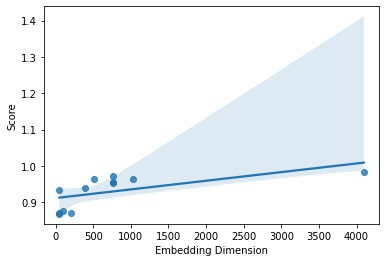

In [97]:
sns.regplot(x=results_df['Embedding Dimension'], y=results_df.Score, ci=95, truncate=True);

## Notes
* General Trend
  * More Embeddings = Better Performance
* BERT AWE vs CLS Token 
  * CLS Token is trained using NSP
  * Fine tune to improve performance
* Doc2Vec
  * Suffers from smallish vocabulary
  * Only uses ClickBait data when creating its joint embedding
* Word2Vec
  * Larger embeddings perform better than smaller
  * Invest more time in pre-processing (stopwords, lemma, stem)
* InferSent / Contrastive Tension are SOTA
  * InferSent performs well on this dataset
